In [1]:
%matplotlib inline

import math

import numpy as np

from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [2]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

colormap = plt.get_cmap('rainbow')

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

In [3]:
N = 25 #Number of experiments
size_of_msg = 0 #number of relevant bytes in a message (to be computed as we load the logs)
size_of_interaction = 3 #number of messages in complete interactions between client and server

def logToPositions(filename):
    global size_of_msg
    file = open(filename)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith('#CLI: Heh, heh, heh... what a mess!'):
            raise Exception('There was an error in the execution of this protocol ' + filename)
        elif line.startswith('#CLI:') or line.startswith('#APP:'):
            continue
        elif line.startswith('#'):
            positions = line[1:].strip().split(',')[:-1]
            if (size_of_msg == 0):
                size_of_msg=len(positions)
            for p in positions:
                yield float(p)
    if not found_christmas:
        print('WARNING! Logs may not be complete for ' + filename)

In [4]:
def  loadAllPositions(base, N, pad=False):
    all_positions = []
    max_len = 0
    for i in range(1,N+1):
        positions = list(logToPositions(base+str(i)+'.log'))
        if len(positions) > max_len:
            max_len = len(positions)
        all_positions.append(np.array(list(positions)))
    if pad:
        for i in range(0,len(all_positions)):
            all_positions[i] = np.pad(all_positions[i], (0, max_len-len(all_positions[i])), 'constant', constant_values=np.nan)        
    return all_positions

WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs1.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs2.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs3.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs5.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs6.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs8.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs9.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs10.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs11.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs12.log
WARNING! Logs may not be co

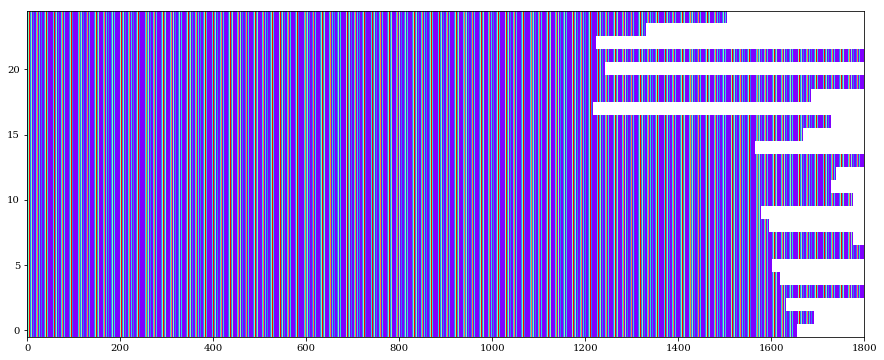

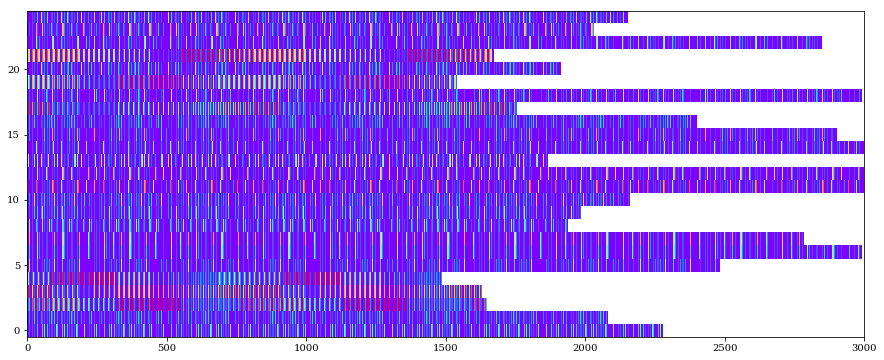

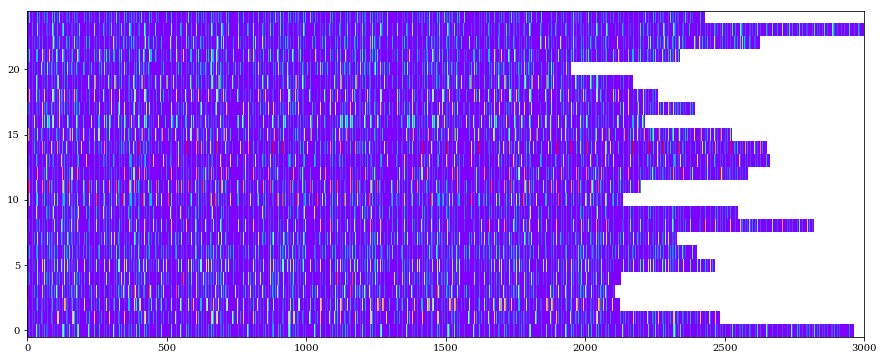

In [5]:
base_dir = '../../../target/thingml-bytes-logs/nodejs/'

base_positions = np.array(loadAllPositions(base_dir+'base/nodejs', N, pad=True))
static_positions = np.array(loadAllPositions(base_dir+'static/nodejs', N, pad=True))
runtime_positions = np.array(loadAllPositions(base_dir+'dynamic/nodejs', N, pad=True))

plt.figure(1, figsize=(15,6))
plt.imshow(base_positions, interpolation='nearest', origin='lower', aspect='auto', cmap=colormap)
plt.savefig('picture_raw_positions_base.png', dpi=300)
plt.show()
plt.figure(2, figsize=(15,6))
plt.imshow(static_positions, interpolation='nearest', origin='lower', aspect='auto', cmap=colormap)
plt.savefig('picture_raw_positions_static.png', dpi=300)
plt.show()
plt.figure(3, figsize=(15,6))
plt.imshow(runtime_positions, interpolation='nearest', origin='lower', aspect='auto', cmap=colormap)
plt.savefig('picture_raw_positions_runtime.png', dpi=300)
plt.show()

In [6]:
def split_train_test(data, train_ratio = 0.67):
    train_test = np.empty([len(data),2], dtype=object)
    for i in range(0,len(data)):
        train_size = int(len(data[i]) * train_ratio)
        test_size = len(data[i]) - train_size
        train, test = data[i][0:train_size], data[i][train_size:len(data[i])]
        train_test[i][0] = train 
        train_test[i][1] = test
    return train_test

#Scale data to fit into y=[0,1]
#train = MinMaxScaler().fit_transform(train.reshape(-1, 1))
#test = MinMaxScaler().fit_transform(test.reshape(-1, 1))

base_positions = np.array(loadAllPositions(base_dir+'base/nodejs', N))
static_positions = np.array(loadAllPositions(base_dir+'static/nodejs', N))
runtime_positions = np.array(loadAllPositions(base_dir+'dynamic/nodejs', N))

base = split_train_test(base_positions)
static = split_train_test(static_positions)
runtime = split_train_test(runtime_positions)

base_train = np.array(base[:, 0])
base_test = np.array(base[:, 1])
static_train = np.array(static[:, 0])
static_test = np.array(static[:, 1])
runtime_train = np.array(runtime[:, 0])
runtime_test = np.array(runtime[:, 1])

WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs1.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs2.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs3.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs5.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs6.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs8.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs9.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs10.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs11.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs12.log
WARNING! Logs may not be co

In [7]:
number_of_interactions = 3
size_of_window = number_of_interactions * size_of_interaction * size_of_msg

"""
See https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg   

In [8]:
def reshape(train, test):
    train_X = np.array(train.iloc[:,0:-1])
    train_Y = np.array(train.iloc[:,-1])
    test_X = np.array(test.iloc[:,0:-1])
    test_Y = np.array(test.iloc[:,-1])

    train_Y = np.reshape(train_Y, (train_Y.shape[0],1))
    test_Y = np.reshape(test_Y, (test_Y.shape[0],1))

    #FIXME: make a function
    n = train_X.shape[0]
    L = 3
    X_train_seq = []
    Y_train_seq = []
    for k in range(n - L + 1):
        X_train_seq.append(train_X[k : k + L])
        Y_train_seq.append(train_Y[k : k + L])
    train_X = np.array(X_train_seq)
    train_Y = np.array(Y_train_seq)

    #FIXME: make a function
    n = test_X.shape[0]
    L = 3
    X_test_seq = []
    Y_test_seq = []
    for k in range(n - L + 1):
        X_test_seq.append(test_X[k : k + L])
        Y_test_seq.append(test_Y[k : k + L])
    test_X = np.array(X_test_seq)
    test_Y = np.array(Y_test_seq)
    
    return train_X, train_Y, test_X, test_Y

def keras_model(x, y):
    model = keras.Sequential()
    model.add(keras.layers.Dense(x, input_shape=(y, x)))
    model.add(keras.layers.LSTM(x, input_shape=(y, x), return_sequences=True))
    model.add(keras.layers.Dense(x))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mse", optimizer="adam")
    return model

def train_and_save(model, train_X, train_Y, test_X, test_Y, mode, xp):
    model.fit(train_X, train_Y, batch_size=12, epochs=train_X.shape[2]*2, verbose=1)
    model.summary()

    json = model.to_json()
    text_file = open(base_dir + mode + str(xp) + '.json', "w")
    text_file.write(json)
    text_file.close()

    keras.models.save_model(model, base_dir + mode + str(xp) + '.h5', overwrite=True, include_optimizer=True)
    result = model.evaluate(test_X, test_Y)
    print(result)
    return model

In [9]:
def predict(model, test_X, test_Y):

    predictions = model.predict(test_X)
    predictions = np.round(predictions)

#     plt.figure(4, figsize=(20,15))
#     plt.plot(predictions.flatten())
#     plt.plot(test_Y.flatten())
#     plt.show()

    error = np.abs(test_Y.flatten() - predictions.flatten())
    condition = np.equal(error, 0)
    matches = np.extract(condition, error)
    
#     plt.figure(5, figsize=(20,15))
#     plt.plot(error)
#     plt.show()

    RMSD = round(math.sqrt(np.sum(error**2)/len(error)),2)
    match_ratio = round((len(matches)/len(error)*100),2)

    return match_ratio, RMSD

In [10]:
def xp(train_set, test_set, mode):
    print('xp ', mode)
    for i in range(0, N):
        print('    #', str(i))
        train = series_to_supervised(list(train_set[i]), size_of_window, 1)
        test = series_to_supervised(list(test_set[i]), size_of_window, 1) 
        train_X, train_Y, test_X, test_Y = reshape(train, test)
        model = keras_model(train_X.shape[2], train_X.shape[1])
        model = train_and_save(model, train_X, train_Y, test_X, test_Y, mode, i)
        match_ratio, RMSD = predict(model, test_X, test_Y)
        print('RMSD = ', RMSD)
        print(match_ratio, '% match')
        yield match_ratio, RMSD

In [11]:
runtime_xp = xp(runtime_train, runtime_test, 'runtime')
results = list(runtime_xp)
results

xp  runtime
    # 0
Epoch 1/108
1929/1929 [==============================] - 2s 894us/step - loss: 0.6568
Epoch 2/108
1929/1929 [==============================] - 1s 274us/step - loss: 0.3143
Epoch 3/108
1929/1929 [==============================] - 1s 278us/step - loss: 0.2206
Epoch 4/108
1929/1929 [==============================] - 1s 274us/step - loss: 0.1722
Epoch 5/108
1929/1929 [==============================] - 1s 272us/step - loss: 0.1497
Epoch 6/108
1929/1929 [==============================] - 1s 274us/step - loss: 0.1374
Epoch 7/108
1929/1929 [==============================] - 1s 276us/step - loss: 0.1162
Epoch 8/108
1929/1929 [==============================] - 1s 280us/step - loss: 0.1105
Epoch 9/108
1929/1929 [==============================] - 1s 280us/step - loss: 0.0964
Epoch 10/108
1929/1929 [==============================] - 1s 276us/step - loss: 0.0920
Epoch 11/108
1929/1929 [==============================] - 1s 276us/step - loss: 0.0893
Epoch 12/108
1929/1929 [========

Epoch 95/108
1929/1929 [==============================] - 1s 280us/step - loss: 0.0371 0s - lo
Epoch 96/108
1929/1929 [==============================] - 1s 284us/step - loss: 0.0392
Epoch 97/108
1929/1929 [==============================] - 1s 276us/step - loss: 0.0381
Epoch 98/108
1929/1929 [==============================] - 1s 274us/step - loss: 0.0389
Epoch 99/108
1929/1929 [==============================] - 1s 278us/step - loss: 0.0371
Epoch 100/108
1929/1929 [==============================] - 1s 274us/step - loss: 0.0383
Epoch 101/108
1929/1929 [==============================] - 1s 276us/step - loss: 0.0377
Epoch 102/108
1929/1929 [==============================] - 1s 274us/step - loss: 0.0371
Epoch 103/108
1929/1929 [==============================] - 1s 278us/step - loss: 0.0366
Epoch 104/108
1929/1929 [==============================] - 1s 278us/step - loss: 0.0395
Epoch 105/108
1929/1929 [==============================] - 1s 276us/step - loss: 0.0382
Epoch 106/108
1929/1929 [====

1608/1608 [==============================] - 0s 261us/step - loss: 0.4193
Epoch 70/108
1608/1608 [==============================] - 0s 263us/step - loss: 0.4137
Epoch 71/108
1608/1608 [==============================] - 0s 274us/step - loss: 0.4170
Epoch 72/108
1608/1608 [==============================] - 0s 273us/step - loss: 0.4105
Epoch 73/108
1608/1608 [==============================] - 0s 291us/step - loss: 0.4205
Epoch 74/108
1608/1608 [==============================] - 0s 271us/step - loss: 0.4154
Epoch 75/108
1608/1608 [==============================] - 0s 274us/step - loss: 0.4227
Epoch 76/108
1608/1608 [==============================] - 0s 295us/step - loss: 0.4191
Epoch 77/108
1608/1608 [==============================] - 0s 252us/step - loss: 0.4119
Epoch 78/108
1608/1608 [==============================] - 0s 252us/step - loss: 0.4095
Epoch 79/108
1608/1608 [==============================] - 0s 258us/step - loss: 0.4081
Epoch 80/108
1608/1608 [==============================] 

1367/1367 [==============================] - 0s 255us/step - loss: 0.1216
Epoch 45/108
1367/1367 [==============================] - 0s 247us/step - loss: 0.1321
Epoch 46/108
1367/1367 [==============================] - 0s 246us/step - loss: 0.1319
Epoch 47/108
1367/1367 [==============================] - 0s 247us/step - loss: 0.1369
Epoch 48/108
1367/1367 [==============================] - 0s 251us/step - loss: 0.1254
Epoch 49/108
1367/1367 [==============================] - 0s 244us/step - loss: 0.1239
Epoch 50/108
1367/1367 [==============================] - 0s 246us/step - loss: 0.1191
Epoch 51/108
1367/1367 [==============================] - 0s 250us/step - loss: 0.1225
Epoch 52/108
1367/1367 [==============================] - 0s 249us/step - loss: 0.1195
Epoch 53/108
1367/1367 [==============================] - 0s 245us/step - loss: 0.1260
Epoch 54/108
1367/1367 [==============================] - 0s 247us/step - loss: 0.1260
Epoch 55/108
1367/1367 [==============================] 

1355/1355 [==============================] - 0s 249us/step - loss: 0.3186
Epoch 20/108
1355/1355 [==============================] - 0s 246us/step - loss: 0.3115
Epoch 21/108
1355/1355 [==============================] - 0s 246us/step - loss: 0.3233
Epoch 22/108
1355/1355 [==============================] - 0s 247us/step - loss: 0.3227
Epoch 23/108
1355/1355 [==============================] - 0s 247us/step - loss: 0.3164
Epoch 24/108
1355/1355 [==============================] - 0s 242us/step - loss: 0.3091
Epoch 25/108
1355/1355 [==============================] - 0s 243us/step - loss: 0.3179
Epoch 26/108
1355/1355 [==============================] - 0s 247us/step - loss: 0.3154
Epoch 27/108
1355/1355 [==============================] - 0s 246us/step - loss: 0.3147
Epoch 28/108
1355/1355 [==============================] - 0s 243us/step - loss: 0.3151
Epoch 29/108
1355/1355 [==============================] - 0s 249us/step - loss: 0.3140
Epoch 30/108
1355/1355 [==============================] 

639/639 [==============================] - 0s 501us/step
0.298477219829
RMSD =  0.57
94.37 % match
    # 4
Epoch 1/108
1371/1371 [==============================] - 2s 1ms/step - loss: 1.3481
Epoch 2/108
1371/1371 [==============================] - 0s 249us/step - loss: 0.5304
Epoch 3/108
1371/1371 [==============================] - 0s 248us/step - loss: 0.3783
Epoch 4/108
1371/1371 [==============================] - 0s 249us/step - loss: 0.3081
Epoch 5/108
1371/1371 [==============================] - 0s 253us/step - loss: 0.2797
Epoch 6/108
1371/1371 [==============================] - 0s 253us/step - loss: 0.2607
Epoch 7/108
1371/1371 [==============================] - 0s 250us/step - loss: 0.2289
Epoch 8/108
1371/1371 [==============================] - 0s 259us/step - loss: 0.2195
Epoch 9/108
1371/1371 [==============================] - 0s 253us/step - loss: 0.2017
Epoch 10/108
1371/1371 [==============================] - 0s 254us/step - loss: 0.2089
Epoch 11/108
1371/1371 [==========

1371/1371 [==============================] - 0s 265us/step - loss: 0.1024
Epoch 94/108
1371/1371 [==============================] - 0s 249us/step - loss: 0.1015
Epoch 95/108
1371/1371 [==============================] - 0s 249us/step - loss: 0.1029
Epoch 96/108
1371/1371 [==============================] - 0s 256us/step - loss: 0.1030
Epoch 97/108
1371/1371 [==============================] - 0s 245us/step - loss: 0.1002
Epoch 98/108
1371/1371 [==============================] - 0s 249us/step - loss: 0.1024
Epoch 99/108
1371/1371 [==============================] - 0s 251us/step - loss: 0.1007
Epoch 100/108
1371/1371 [==============================] - 0s 252us/step - loss: 0.1039
Epoch 101/108
1371/1371 [==============================] - 0s 250us/step - loss: 0.0978
Epoch 102/108
1371/1371 [==============================] - 0s 255us/step - loss: 0.0968
Epoch 103/108
1371/1371 [==============================] - 0s 249us/step - loss: 0.0970
Epoch 104/108
1371/1371 [===========================

1596/1596 [==============================] - 0s 253us/step - loss: 0.2991
Epoch 68/108
1596/1596 [==============================] - 0s 251us/step - loss: 0.2965
Epoch 69/108
1596/1596 [==============================] - 0s 251us/step - loss: 0.3118
Epoch 70/108
1596/1596 [==============================] - 0s 250us/step - loss: 0.3006
Epoch 71/108
1596/1596 [==============================] - 0s 250us/step - loss: 0.2974
Epoch 72/108
1596/1596 [==============================] - 0s 249us/step - loss: 0.3000
Epoch 73/108
1596/1596 [==============================] - 0s 249us/step - loss: 0.3046
Epoch 74/108
1596/1596 [==============================] - 0s 248us/step - loss: 0.3011
Epoch 75/108
1596/1596 [==============================] - 0s 250us/step - loss: 0.2959
Epoch 76/108
1596/1596 [==============================] - 0s 251us/step - loss: 0.2977
Epoch 77/108
1596/1596 [==============================] - 0s 253us/step - loss: 0.2962
Epoch 78/108
1596/1596 [==============================] 

1552/1552 [==============================] - 0s 256us/step - loss: 0.0599
Epoch 42/108
1552/1552 [==============================] - 0s 253us/step - loss: 0.0613
Epoch 43/108
1552/1552 [==============================] - 0s 251us/step - loss: 0.0612
Epoch 44/108
1552/1552 [==============================] - 0s 256us/step - loss: 0.0611
Epoch 45/108
1552/1552 [==============================] - 0s 253us/step - loss: 0.0596
Epoch 46/108
1552/1552 [==============================] - 0s 259us/step - loss: 0.0579
Epoch 47/108
1552/1552 [==============================] - 0s 260us/step - loss: 0.0593 0s - loss:
Epoch 48/108
1552/1552 [==============================] - 0s 251us/step - loss: 0.0595
Epoch 49/108
1552/1552 [==============================] - 0s 256us/step - loss: 0.0589
Epoch 50/108
1552/1552 [==============================] - 0s 255us/step - loss: 0.0594
Epoch 51/108
1552/1552 [==============================] - 0s 255us/step - loss: 0.0597
Epoch 52/108
1552/1552 [=====================

Epoch 16/108
1503/1503 [==============================] - 0s 256us/step - loss: 0.3313
Epoch 17/108
1503/1503 [==============================] - 0s 256us/step - loss: 0.3295
Epoch 18/108
1503/1503 [==============================] - 0s 254us/step - loss: 0.3161
Epoch 19/108
1503/1503 [==============================] - 0s 253us/step - loss: 0.3205
Epoch 20/108
1503/1503 [==============================] - 0s 256us/step - loss: 0.3353
Epoch 21/108
1503/1503 [==============================] - 0s 254us/step - loss: 0.3136
Epoch 22/108
1503/1503 [==============================] - 0s 253us/step - loss: 0.3145
Epoch 23/108
1503/1503 [==============================] - 0s 255us/step - loss: 0.3084
Epoch 24/108
1503/1503 [==============================] - 0s 254us/step - loss: 0.3178
Epoch 25/108
1503/1503 [==============================] - 0s 256us/step - loss: 0.3147
Epoch 26/108
1503/1503 [==============================] - 0s 254us/step - loss: 0.3030
Epoch 27/108
1503/1503 [===================

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 3, 54)             2970      
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 54)             23544     
_________________________________________________________________
dense_22 (Dense)             (None, 3, 54)             2970      
_________________________________________________________________
dense_23 (Dense)             (None, 3, 1)              55        
Total params: 29,539
Trainable params: 29,539
Non-trainable params: 0
_________________________________________________________________
713/713 [==============================] - 1s 726us/step
0.765794693405
RMSD =  0.89
88.22 % match
    # 8
Epoch 1/108
1833/1833 [==============================] - 2s 1ms/step - loss: 1.5037
Epoch 2/108
1833/1833 [==============================] - 0s 256us/step - loss: 

1833/1833 [==============================] - 0s 260us/step - loss: 0.2858
Epoch 85/108
1833/1833 [==============================] - 0s 252us/step - loss: 0.2762
Epoch 86/108
1833/1833 [==============================] - 0s 256us/step - loss: 0.2736
Epoch 87/108
1833/1833 [==============================] - 0s 251us/step - loss: 0.2683
Epoch 88/108
1833/1833 [==============================] - 0s 257us/step - loss: 0.2720
Epoch 89/108
1833/1833 [==============================] - 0s 251us/step - loss: 0.2625
Epoch 90/108
1833/1833 [==============================] - 0s 259us/step - loss: 0.2621
Epoch 91/108
1833/1833 [==============================] - 0s 255us/step - loss: 0.2707
Epoch 92/108
1833/1833 [==============================] - 0s 254us/step - loss: 0.2677
Epoch 93/108
1833/1833 [==============================] - 0s 257us/step - loss: 0.2637
Epoch 94/108
1833/1833 [==============================] - 0s 254us/step - loss: 0.2630
Epoch 95/108
1833/1833 [==============================] 

1652/1652 [==============================] - 0s 260us/step - loss: 0.0866
Epoch 60/108
1652/1652 [==============================] - 0s 257us/step - loss: 0.0889
Epoch 61/108
1652/1652 [==============================] - 0s 256us/step - loss: 0.0847
Epoch 62/108
1652/1652 [==============================] - 0s 266us/step - loss: 0.0860
Epoch 63/108
1652/1652 [==============================] - 0s 259us/step - loss: 0.0863
Epoch 64/108
1652/1652 [==============================] - 0s 261us/step - loss: 0.0848
Epoch 65/108
1652/1652 [==============================] - 0s 260us/step - loss: 0.0846
Epoch 66/108
1652/1652 [==============================] - 0s 257us/step - loss: 0.0836
Epoch 67/108
1652/1652 [==============================] - 0s 257us/step - loss: 0.0845
Epoch 68/108
1652/1652 [==============================] - 0s 263us/step - loss: 0.0927
Epoch 69/108
1652/1652 [==============================] - 0s 261us/step - loss: 0.0860
Epoch 70/108
1652/1652 [==============================] 

1375/1375 [==============================] - 0s 269us/step - loss: 0.1845
Epoch 35/108
1375/1375 [==============================] - 0s 260us/step - loss: 0.1775
Epoch 36/108
1375/1375 [==============================] - 0s 260us/step - loss: 0.1793
Epoch 37/108
1375/1375 [==============================] - 0s 262us/step - loss: 0.1812
Epoch 38/108
1375/1375 [==============================] - 0s 264us/step - loss: 0.1779
Epoch 39/108
1375/1375 [==============================] - 0s 260us/step - loss: 0.1760
Epoch 40/108
1375/1375 [==============================] - 0s 268us/step - loss: 0.1742
Epoch 41/108
1375/1375 [==============================] - 0s 264us/step - loss: 0.1762
Epoch 42/108
1375/1375 [==============================] - 0s 265us/step - loss: 0.1760
Epoch 43/108
1375/1375 [==============================] - 0s 264us/step - loss: 0.1721
Epoch 44/108
1375/1375 [==============================] - 0s 260us/step - loss: 0.1749
Epoch 45/108
1375/1375 [==============================] 

1419/1419 [==============================] - 0s 267us/step - loss: 0.5217
Epoch 10/108
1419/1419 [==============================] - 0s 263us/step - loss: 0.5139
Epoch 11/108
1419/1419 [==============================] - 0s 261us/step - loss: 0.4887
Epoch 12/108
1419/1419 [==============================] - 0s 267us/step - loss: 0.5048
Epoch 13/108
1419/1419 [==============================] - 0s 266us/step - loss: 0.4909
Epoch 14/108
1419/1419 [==============================] - 0s 261us/step - loss: 0.4836
Epoch 15/108
1419/1419 [==============================] - 0s 264us/step - loss: 0.4964
Epoch 16/108
1419/1419 [==============================] - 0s 264us/step - loss: 0.4848
Epoch 17/108
1419/1419 [==============================] - 0s 264us/step - loss: 0.4715
Epoch 18/108
1419/1419 [==============================] - 0s 265us/step - loss: 0.4818
Epoch 19/108
1419/1419 [==============================] - 0s 268us/step - loss: 0.4759
Epoch 20/108
1419/1419 [==============================] 

1419/1419 [==============================] - 0s 268us/step - loss: 0.4539
Epoch 104/108
1419/1419 [==============================] - 0s 265us/step - loss: 0.4504
Epoch 105/108
1419/1419 [==============================] - 0s 257us/step - loss: 0.4543
Epoch 106/108
1419/1419 [==============================] - 0s 262us/step - loss: 0.4495
Epoch 107/108
1419/1419 [==============================] - 0s 264us/step - loss: 0.4507
Epoch 108/108
1419/1419 [==============================] - 0s 263us/step - loss: 0.4576
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 3, 54)             2970      
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 54)             23544     
_________________________________________________________________
dense_34 (Dense)             (None, 3, 54)             2970      
________________________

1676/1676 [==============================] - 0s 270us/step - loss: 0.3453
Epoch 79/108
1676/1676 [==============================] - 0s 263us/step - loss: 0.3496
Epoch 80/108
1676/1676 [==============================] - 0s 264us/step - loss: 0.3608
Epoch 81/108
1676/1676 [==============================] - 0s 267us/step - loss: 0.3530
Epoch 82/108
1676/1676 [==============================] - 0s 263us/step - loss: 0.3521
Epoch 83/108
1676/1676 [==============================] - 0s 263us/step - loss: 0.3469
Epoch 84/108
1676/1676 [==============================] - 0s 261us/step - loss: 0.3549
Epoch 85/108
1676/1676 [==============================] - 0s 269us/step - loss: 0.3546
Epoch 86/108
1676/1676 [==============================] - 0s 262us/step - loss: 0.3470
Epoch 87/108
1676/1676 [==============================] - 0s 267us/step - loss: 0.3486
Epoch 88/108
1676/1676 [==============================] - 0s 266us/step - loss: 0.3486
Epoch 89/108
1676/1676 [==============================] 

1728/1728 [==============================] - 0s 269us/step - loss: 0.2118
Epoch 54/108
1728/1728 [==============================] - 0s 271us/step - loss: 0.2087
Epoch 55/108
1728/1728 [==============================] - 0s 264us/step - loss: 0.2082
Epoch 56/108
1728/1728 [==============================] - 0s 267us/step - loss: 0.2124
Epoch 57/108
1728/1728 [==============================] - 0s 267us/step - loss: 0.2107
Epoch 58/108
1728/1728 [==============================] - 0s 265us/step - loss: 0.2114
Epoch 59/108
1728/1728 [==============================] - 0s 265us/step - loss: 0.2116
Epoch 60/108
1728/1728 [==============================] - 0s 267us/step - loss: 0.2084
Epoch 61/108
1728/1728 [==============================] - 0s 265us/step - loss: 0.2089
Epoch 62/108
1728/1728 [==============================] - 0s 262us/step - loss: 0.2088
Epoch 63/108
1728/1728 [==============================] - 0s 266us/step - loss: 0.2101
Epoch 64/108
1728/1728 [==============================] 

1720/1720 [==============================] - 0s 279us/step - loss: 0.2442
Epoch 29/108
1720/1720 [==============================] - 0s 270us/step - loss: 0.2247
Epoch 30/108
1720/1720 [==============================] - 0s 265us/step - loss: 0.2366
Epoch 31/108
1720/1720 [==============================] - 0s 273us/step - loss: 0.2225
Epoch 32/108
1720/1720 [==============================] - 0s 267us/step - loss: 0.2146
Epoch 33/108
1720/1720 [==============================] - 0s 269us/step - loss: 0.2345
Epoch 34/108
1720/1720 [==============================] - 0s 266us/step - loss: 0.2317
Epoch 35/108
1720/1720 [==============================] - 0s 269us/step - loss: 0.2051
Epoch 36/108
1720/1720 [==============================] - 0s 274us/step - loss: 0.2090
Epoch 37/108
1720/1720 [==============================] - 0s 268us/step - loss: 0.2259
Epoch 38/108
1720/1720 [==============================] - 0s 268us/step - loss: 0.2088
Epoch 39/108
1720/1720 [==============================] 

1636/1636 [==============================] - 0s 281us/step - loss: 0.5461
Epoch 4/108
1636/1636 [==============================] - 0s 276us/step - loss: 0.4937
Epoch 5/108
1636/1636 [==============================] - 0s 272us/step - loss: 0.4180
Epoch 6/108
1636/1636 [==============================] - 0s 270us/step - loss: 0.4109
Epoch 7/108
1636/1636 [==============================] - 0s 277us/step - loss: 0.3792
Epoch 8/108
1636/1636 [==============================] - 0s 279us/step - loss: 0.3566
Epoch 9/108
1636/1636 [==============================] - 0s 273us/step - loss: 0.3330
Epoch 10/108
1636/1636 [==============================] - 0s 276us/step - loss: 0.3395
Epoch 11/108
1636/1636 [==============================] - 0s 272us/step - loss: 0.3250
Epoch 12/108
1636/1636 [==============================] - 0s 270us/step - loss: 0.3113
Epoch 13/108
1636/1636 [==============================] - 0s 278us/step - loss: 0.3015
Epoch 14/108
1636/1636 [==============================] - 0s 2

1636/1636 [==============================] - 0s 270us/step - loss: 0.1656
Epoch 98/108
1636/1636 [==============================] - 0s 272us/step - loss: 0.1656
Epoch 99/108
1636/1636 [==============================] - 0s 272us/step - loss: 0.1596
Epoch 100/108
1636/1636 [==============================] - 0s 268us/step - loss: 0.1626
Epoch 101/108
1636/1636 [==============================] - 0s 271us/step - loss: 0.1675
Epoch 102/108
1636/1636 [==============================] - 0s 274us/step - loss: 0.1620
Epoch 103/108
1636/1636 [==============================] - 0s 272us/step - loss: 0.1600
Epoch 104/108
1636/1636 [==============================] - 0s 273us/step - loss: 0.1669
Epoch 105/108
1636/1636 [==============================] - 0s 272us/step - loss: 0.1664
Epoch 106/108
1636/1636 [==============================] - 0s 270us/step - loss: 0.1654
Epoch 107/108
1636/1636 [==============================] - 0s 273us/step - loss: 0.1623
Epoch 108/108
1636/1636 [=======================

1427/1427 [==============================] - 0s 282us/step - loss: 0.1405
Epoch 73/108
1427/1427 [==============================] - 0s 275us/step - loss: 0.1422
Epoch 74/108
1427/1427 [==============================] - 0s 271us/step - loss: 0.1376
Epoch 75/108
1427/1427 [==============================] - 0s 278us/step - loss: 0.1387
Epoch 76/108
1427/1427 [==============================] - 0s 271us/step - loss: 0.1359
Epoch 77/108
1427/1427 [==============================] - 0s 273us/step - loss: 0.1365
Epoch 78/108
1427/1427 [==============================] - 0s 275us/step - loss: 0.1361
Epoch 79/108
1427/1427 [==============================] - 0s 273us/step - loss: 0.1356
Epoch 80/108
1427/1427 [==============================] - 0s 275us/step - loss: 0.1327
Epoch 81/108
1427/1427 [==============================] - 0s 271us/step - loss: 0.1349
Epoch 82/108
1427/1427 [==============================] - 0s 271us/step - loss: 0.1339
Epoch 83/108
1427/1427 [==============================] 

1547/1547 [==============================] - 0s 277us/step - loss: 0.3077
Epoch 48/108
1547/1547 [==============================] - 0s 276us/step - loss: 0.3110
Epoch 49/108
1547/1547 [==============================] - 0s 274us/step - loss: 0.2984
Epoch 50/108
1547/1547 [==============================] - 0s 272us/step - loss: 0.3037
Epoch 51/108
1547/1547 [==============================] - 0s 277us/step - loss: 0.2948
Epoch 52/108
1547/1547 [==============================] - 0s 272us/step - loss: 0.2962
Epoch 53/108
1547/1547 [==============================] - 0s 275us/step - loss: 0.2992
Epoch 54/108
1547/1547 [==============================] - 0s 275us/step - loss: 0.2942
Epoch 55/108
1547/1547 [==============================] - 0s 277us/step - loss: 0.2941
Epoch 56/108
1547/1547 [==============================] - 0s 275us/step - loss: 0.2929
Epoch 57/108
1547/1547 [==============================] - 0s 276us/step - loss: 0.2962
Epoch 58/108
1547/1547 [==============================] 

1459/1459 [==============================] - 0s 280us/step - loss: 0.2489
Epoch 23/108
1459/1459 [==============================] - 0s 282us/step - loss: 0.2476
Epoch 24/108
1459/1459 [==============================] - 0s 277us/step - loss: 0.2518
Epoch 25/108
1459/1459 [==============================] - 0s 278us/step - loss: 0.2524
Epoch 26/108
1459/1459 [==============================] - 0s 279us/step - loss: 0.2472
Epoch 27/108
1459/1459 [==============================] - 0s 282us/step - loss: 0.2339
Epoch 28/108
1459/1459 [==============================] - 0s 281us/step - loss: 0.2338
Epoch 29/108
1459/1459 [==============================] - 0s 277us/step - loss: 0.2371
Epoch 30/108
1459/1459 [==============================] - 0s 277us/step - loss: 0.2375
Epoch 31/108
1459/1459 [==============================] - 0s 282us/step - loss: 0.2274
Epoch 32/108
1459/1459 [==============================] - 0s 280us/step - loss: 0.2398
Epoch 33/108
1459/1459 [==============================] 

691/691 [==============================] - 1s 2ms/step
0.832638518445
RMSD =  0.91
87.7 % match
    # 19
Epoch 1/108
1399/1399 [==============================] - 4s 3ms/step - loss: 1.9439
Epoch 2/108
1399/1399 [==============================] - 0s 277us/step - loss: 0.7337
Epoch 3/108
1399/1399 [==============================] - 0s 278us/step - loss: 0.4128
Epoch 4/108
1399/1399 [==============================] - 0s 284us/step - loss: 0.3108
Epoch 5/108
1399/1399 [==============================] - 0s 278us/step - loss: 0.2319
Epoch 6/108
1399/1399 [==============================] - 0s 280us/step - loss: 0.1977
Epoch 7/108
1399/1399 [==============================] - 0s 274us/step - loss: 0.1761
Epoch 8/108
1399/1399 [==============================] - 0s 280us/step - loss: 0.1654
Epoch 9/108
1399/1399 [==============================] - 0s 280us/step - loss: 0.1547
Epoch 10/108
1399/1399 [==============================] - 0s 280us/step - loss: 0.1390
Epoch 11/108
1399/1399 [============

1399/1399 [==============================] - 0s 280us/step - loss: 0.0501
Epoch 95/108
1399/1399 [==============================] - 0s 273us/step - loss: 0.0507
Epoch 96/108
1399/1399 [==============================] - 0s 277us/step - loss: 0.0538
Epoch 97/108
1399/1399 [==============================] - 0s 277us/step - loss: 0.0553
Epoch 98/108
1399/1399 [==============================] - 0s 277us/step - loss: 0.0513
Epoch 99/108
1399/1399 [==============================] - 0s 282us/step - loss: 0.0496
Epoch 100/108
1399/1399 [==============================] - 0s 279us/step - loss: 0.0612
Epoch 101/108
1399/1399 [==============================] - 0s 277us/step - loss: 0.0550
Epoch 102/108
1399/1399 [==============================] - 0s 281us/step - loss: 0.0484
Epoch 103/108
1399/1399 [==============================] - 0s 277us/step - loss: 0.0482
Epoch 104/108
1399/1399 [==============================] - 0s 278us/step - loss: 0.0469
Epoch 105/108
1399/1399 [==========================

1250/1250 [==============================] - 0s 283us/step - loss: 0.0764
Epoch 70/108
1250/1250 [==============================] - ETA: 0s - loss: 0.070 - 0s 284us/step - loss: 0.0724
Epoch 71/108
1250/1250 [==============================] - 0s 279us/step - loss: 0.0692
Epoch 72/108
1250/1250 [==============================] - 0s 280us/step - loss: 0.0740
Epoch 73/108
1250/1250 [==============================] - 0s 281us/step - loss: 0.0709
Epoch 74/108
1250/1250 [==============================] - 0s 283us/step - loss: 0.0705
Epoch 75/108
1250/1250 [==============================] - 0s 282us/step - loss: 0.0711
Epoch 76/108
1250/1250 [==============================] - 0s 281us/step - loss: 0.0775
Epoch 77/108
1250/1250 [==============================] - 0s 282us/step - loss: 0.0756
Epoch 78/108
1250/1250 [==============================] - 0s 279us/step - loss: 0.0740
Epoch 79/108
1250/1250 [==============================] - 0s 280us/step - loss: 0.0704
Epoch 80/108
1250/1250 [========

Epoch 44/108
1511/1511 [==============================] - 0s 282us/step - loss: 0.1016
Epoch 45/108
1511/1511 [==============================] - 0s 285us/step - loss: 0.1015
Epoch 46/108
1511/1511 [==============================] - 0s 278us/step - loss: 0.0959
Epoch 47/108
1511/1511 [==============================] - 0s 281us/step - loss: 0.0956
Epoch 48/108
1511/1511 [==============================] - 0s 283us/step - loss: 0.1019
Epoch 49/108
1511/1511 [==============================] - 0s 283us/step - loss: 0.0955
Epoch 50/108
1511/1511 [==============================] - 0s 283us/step - loss: 0.1013 0s - loss: 0.
Epoch 51/108
1511/1511 [==============================] - 0s 281us/step - loss: 0.0996
Epoch 52/108
1511/1511 [==============================] - 0s 286us/step - loss: 0.1004
Epoch 53/108
1511/1511 [==============================] - 0s 283us/step - loss: 0.0922 0s - loss: 0.
Epoch 54/108
1511/1511 [==============================] - 0s 283us/step - loss: 0.0927
Epoch 55/108
15

1704/1704 [==============================] - 0s 287us/step - loss: 0.1071
Epoch 19/108
1704/1704 [==============================] - 0s 279us/step - loss: 0.0983
Epoch 20/108
1704/1704 [==============================] - 0s 282us/step - loss: 0.1020
Epoch 21/108
1704/1704 [==============================] - 0s 284us/step - loss: 0.0906
Epoch 22/108
1704/1704 [==============================] - 0s 282us/step - loss: 0.0855
Epoch 23/108
1704/1704 [==============================] - 0s 278us/step - loss: 0.0886
Epoch 24/108
1704/1704 [==============================] - 0s 283us/step - loss: 0.0923
Epoch 25/108
1704/1704 [==============================] - 0s 290us/step - loss: 0.0808
Epoch 26/108
1704/1704 [==============================] - 0s 283us/step - loss: 0.0818
Epoch 27/108
1704/1704 [==============================] - 0s 285us/step - loss: 0.0833
Epoch 28/108
1704/1704 [==============================] - 0s 281us/step - loss: 0.0803
Epoch 29/108
1704/1704 [==============================] 

812/812 [==============================] - 1s 2ms/step
0.532441393348
RMSD =  0.74
79.35 % match
    # 23
Epoch 1/108
1954/1954 [==============================] - 4s 2ms/step - loss: 0.5654
Epoch 2/108
1954/1954 [==============================] - 1s 289us/step - loss: 0.2094
Epoch 3/108
1954/1954 [==============================] - 1s 287us/step - loss: 0.1789
Epoch 4/108
1954/1954 [==============================] - 1s 283us/step - loss: 0.1666
Epoch 5/108
1954/1954 [==============================] - 1s 294us/step - loss: 0.1586
Epoch 6/108
1954/1954 [==============================] - 1s 285us/step - loss: 0.1574
Epoch 7/108
1954/1954 [==============================] - 1s 286us/step - loss: 0.1471
Epoch 8/108
1954/1954 [==============================] - 1s 283us/step - loss: 0.1451
Epoch 9/108
1954/1954 [==============================] - 1s 281us/step - loss: 0.1381
Epoch 10/108
1954/1954 [==============================] - 1s 287us/step - loss: 0.1375
Epoch 11/108
1954/1954 [===========

1954/1954 [==============================] - 1s 295us/step - loss: 0.1098
Epoch 95/108
1954/1954 [==============================] - 1s 290us/step - loss: 0.1061
Epoch 96/108
1954/1954 [==============================] - 1s 292us/step - loss: 0.1075
Epoch 97/108
1954/1954 [==============================] - 1s 289us/step - loss: 0.1047
Epoch 98/108
1954/1954 [==============================] - 1s 295us/step - loss: 0.1057
Epoch 99/108
1954/1954 [==============================] - 1s 296us/step - loss: 0.1064
Epoch 100/108
1954/1954 [==============================] - 1s 289us/step - loss: 0.1060
Epoch 101/108
1954/1954 [==============================] - 1s 296us/step - loss: 0.1071
Epoch 102/108
1954/1954 [==============================] - 1s 289us/step - loss: 0.1053
Epoch 103/108
1954/1954 [==============================] - 1s 294us/step - loss: 0.1077
Epoch 104/108
1954/1954 [==============================] - 1s 290us/step - loss: 0.1052
Epoch 105/108
1954/1954 [==========================

1572/1572 [==============================] - 0s 286us/step - loss: 0.0306
Epoch 70/108
1572/1572 [==============================] - 0s 285us/step - loss: 0.0305
Epoch 71/108
1572/1572 [==============================] - 0s 281us/step - loss: 0.0290
Epoch 72/108
1572/1572 [==============================] - 0s 286us/step - loss: 0.0292
Epoch 73/108
1572/1572 [==============================] - 0s 286us/step - loss: 0.0295
Epoch 74/108
1572/1572 [==============================] - 0s 285us/step - loss: 0.0286
Epoch 75/108
1572/1572 [==============================] - 0s 282us/step - loss: 0.0288
Epoch 76/108
1572/1572 [==============================] - ETA: 0s - loss: 0.028 - 0s 293us/step - loss: 0.0288
Epoch 77/108
1572/1572 [==============================] - 0s 284us/step - loss: 0.0285
Epoch 78/108
1572/1572 [==============================] - 0s 284us/step - loss: 0.0289
Epoch 79/108
1572/1572 [==============================] - 0s 284us/step - loss: 0.0301
Epoch 80/108
1572/1572 [========

[(93.14, 0.42),
 (92.98, 0.82),
 (87.39, 0.83),
 (94.37, 0.57),
 (87.64, 0.67),
 (86.85, 1.04),
 (92.53, 0.37),
 (88.22, 0.89),
 (93.6, 0.78),
 (94.19, 0.48),
 (93.32, 0.68),
 (90.96, 1.05),
 (89.47, 1.18),
 (92.72, 0.57),
 (92.07, 0.74),
 (93.74, 0.73),
 (86.02, 0.8),
 (88.12, 0.95),
 (87.7, 0.91),
 (82.7, 0.64),
 (97.22, 0.26),
 (89.77, 0.73),
 (79.35, 0.74),
 (94.5, 0.48),
 (93.03, 0.31)]

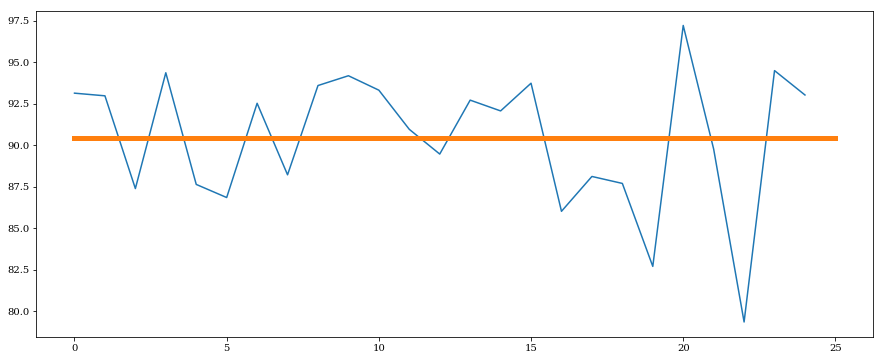

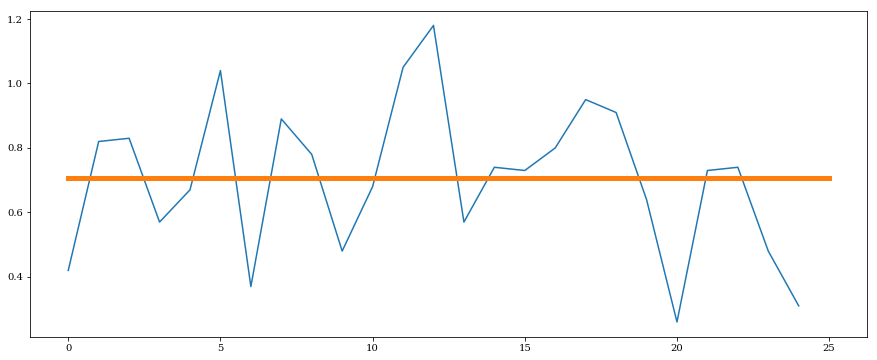

In [12]:
errors = []
RMSDs = []
for e,rms in results:
    errors.append(e)
    RMSDs.append(rms)

plt.figure(4, figsize=(15,6))
plt.plot(errors)
mean = np.mean(errors)
plt.plot([0, len(errors)], [mean, mean], linewidth=5)
plt.show()

plt.figure(5, figsize=(15,6))
plt.plot(RMSDs)
mean = np.mean(RMSDs)
plt.plot([0, len(RMSDs)], [mean, mean], linewidth=5)
plt.show()

In [45]:
def xp2(train_set, test_set, mode):
    for i in range(0,N):
        model = keras.models.load_model(base_dir + mode + str(i) + '.h5')
        model.summary()
        for j in range(0,N):
            print('    using model ', str(i), 'on data coming from ', str(j))
            train = series_to_supervised(list(train_set[j]), size_of_window, 1)
            test = series_to_supervised(list(test_set[j]), size_of_window, 1) 
            train_X, train_Y, test_X, test_Y = reshape(train, test)
            match_ratio, RMSD = predict(model, test_X, test_Y)
            print('RMSD = ', RMSD)
            print(match_ratio, '% match')
            yield match_ratio, RMSD
        
results = xp2(runtime_train, runtime_test, 'runtime')
results = list(results)
results

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3, 54)             2970      
_________________________________________________________________
lstm (LSTM)                  (None, 3, 54)             23544     
_________________________________________________________________
dense_1 (Dense)              (None, 3, 54)             2970      
_________________________________________________________________
dense_2 (Dense)              (None, 3, 1)              55        
Total params: 29,539
Trainable params: 29,539
Non-trainable params: 0
_________________________________________________________________
    using model  0 on data coming from  0
RMSD =  0.42
93.14 % match
    using model  0 on data coming from  1
RMSD =  1.58
66.93 % match
    using model  0 on data coming from  2
RMSD =  2.37
60.05 % match
    using model  0 on data coming from  3
RMSD =  1.76
62.39 % 

RMSD =  1.33
47.49 % match
    using model  3 on data coming from  1
RMSD =  1.1
69.98 % match
    using model  3 on data coming from  2
RMSD =  2.37
43.15 % match
    using model  3 on data coming from  3
RMSD =  0.57
94.37 % match
    using model  3 on data coming from  4
RMSD =  1.54
53.79 % match
    using model  3 on data coming from  5
RMSD =  1.57
57.43 % match
    using model  3 on data coming from  6
RMSD =  1.29
53.17 % match
    using model  3 on data coming from  7
RMSD =  1.5
59.65 % match
    using model  3 on data coming from  8
RMSD =  1.97
54.4 % match
    using model  3 on data coming from  9
RMSD =  1.8
42.49 % match
    using model  3 on data coming from  10
RMSD =  2.08
42.78 % match
    using model  3 on data coming from  11
RMSD =  1.99
65.82 % match
    using model  3 on data coming from  12
RMSD =  1.85
58.52 % match
    using model  3 on data coming from  13
RMSD =  2.05
42.56 % match
    using model  3 on data coming from  14
RMSD =  1.66
58.37 % match
    us

RMSD =  0.37
92.53 % match
    using model  6 on data coming from  7
RMSD =  1.29
65.45 % match
    using model  6 on data coming from  8
RMSD =  1.83
61.26 % match
    using model  6 on data coming from  9
RMSD =  1.38
48.69 % match
    using model  6 on data coming from  10
RMSD =  1.79
68.1 % match
    using model  6 on data coming from  11
RMSD =  2.2
57.63 % match
    using model  6 on data coming from  12
RMSD =  1.99
55.1 % match
    using model  6 on data coming from  13
RMSD =  1.47
62.54 % match
    using model  6 on data coming from  14
RMSD =  2.26
55.81 % match
    using model  6 on data coming from  15
RMSD =  1.97
50.04 % match
    using model  6 on data coming from  16
RMSD =  1.69
58.47 % match
    using model  6 on data coming from  17
RMSD =  1.5
67.57 % match
    using model  6 on data coming from  18
RMSD =  1.79
58.32 % match
    using model  6 on data coming from  19
RMSD =  1.57
49.52 % match
    using model  6 on data coming from  20
RMSD =  1.44
57.54 % match


RMSD =  2.27
52.59 % match
    using model  9 on data coming from  13
RMSD =  1.39
61.69 % match
    using model  9 on data coming from  14
RMSD =  2.41
54.11 % match
    using model  9 on data coming from  15
RMSD =  1.89
39.12 % match
    using model  9 on data coming from  16
RMSD =  1.84
58.67 % match
    using model  9 on data coming from  17
RMSD =  1.84
55.37 % match
    using model  9 on data coming from  18
RMSD =  2.22
50.94 % match
    using model  9 on data coming from  19
RMSD =  1.68
48.21 % match
    using model  9 on data coming from  20
RMSD =  1.76
45.75 % match
    using model  9 on data coming from  21
RMSD =  1.76
61.04 % match
    using model  9 on data coming from  22
RMSD =  1.1
68.84 % match
    using model  9 on data coming from  23
RMSD =  1.15
67.27 % match
    using model  9 on data coming from  24
RMSD =  1.06
65.46 % match
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de

RMSD =  2.0
51.52 % match
    using model  12 on data coming from  19
RMSD =  1.94
48.87 % match
    using model  12 on data coming from  20
RMSD =  1.78
46.83 % match
    using model  12 on data coming from  21
RMSD =  1.61
57.28 % match
    using model  12 on data coming from  22
RMSD =  1.86
43.64 % match
    using model  12 on data coming from  23
RMSD =  1.11
53.71 % match
    using model  12 on data coming from  24
RMSD =  1.26
57.77 % match
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 3, 54)             2970      
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 54)             23544     
_________________________________________________________________
dense_40 (Dense)             (None, 3, 54)             2970      
_________________________________________________________________
dense_41 (Dense)    

RMSD =  1.1
51.16 % match
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 3, 54)             2970      
_________________________________________________________________
lstm_16 (LSTM)               (None, 3, 54)             23544     
_________________________________________________________________
dense_49 (Dense)             (None, 3, 54)             2970      
_________________________________________________________________
dense_50 (Dense)             (None, 3, 1)              55        
Total params: 29,539
Trainable params: 29,539
Non-trainable params: 0
_________________________________________________________________
    using model  16 on data coming from  0
RMSD =  1.37
58.97 % match
    using model  16 on data coming from  1
RMSD =  1.83
55.98 % match
    using model  16 on data coming from  2
RMSD =  1.99
54.52 % match
    using model  16 on data coming

RMSD =  1.24
48.28 % match
    using model  19 on data coming from  1
RMSD =  2.08
36.61 % match
    using model  19 on data coming from  2
RMSD =  2.28
45.37 % match
    using model  19 on data coming from  3
RMSD =  2.35
35.73 % match
    using model  19 on data coming from  4
RMSD =  1.62
38.95 % match
    using model  19 on data coming from  5
RMSD =  2.3
39.89 % match
    using model  19 on data coming from  6
RMSD =  1.29
46.42 % match
    using model  19 on data coming from  7
RMSD =  2.13
44.51 % match
    using model  19 on data coming from  8
RMSD =  2.09
45.71 % match
    using model  19 on data coming from  9
RMSD =  1.21
43.77 % match
    using model  19 on data coming from  10
RMSD =  1.75
51.77 % match
    using model  19 on data coming from  11
RMSD =  2.51
34.53 % match
    using model  19 on data coming from  12
RMSD =  2.59
41.19 % match
    using model  19 on data coming from  13
RMSD =  1.31
54.98 % match
    using model  19 on data coming from  14
RMSD =  2.37
45.

    using model  22 on data coming from  6
RMSD =  1.2
55.71 % match
    using model  22 on data coming from  7
RMSD =  1.87
47.55 % match
    using model  22 on data coming from  8
RMSD =  2.07
47.2 % match
    using model  22 on data coming from  9
RMSD =  0.67
84.27 % match
    using model  22 on data coming from  10
RMSD =  2.07
56.39 % match
    using model  22 on data coming from  11
RMSD =  2.55
49.18 % match
    using model  22 on data coming from  12
RMSD =  2.28
42.4 % match
    using model  22 on data coming from  13
RMSD =  1.42
58.29 % match
    using model  22 on data coming from  14
RMSD =  2.52
43.37 % match
    using model  22 on data coming from  15
RMSD =  2.12
37.96 % match
    using model  22 on data coming from  16
RMSD =  1.75
59.06 % match
    using model  22 on data coming from  17
RMSD =  1.87
51.34 % match
    using model  22 on data coming from  18
RMSD =  2.0
54.08 % match
    using model  22 on data coming from  19
RMSD =  1.8
44.18 % match
    using model

[(93.14, 0.42),
 (66.93, 1.58),
 (60.05, 2.37),
 (62.39, 1.76),
 (74.09, 1.27),
 (66.49, 1.8),
 (67.8, 1.08),
 (66.81, 1.52),
 (68.23, 1.73),
 (66.37, 1.0),
 (61.43, 2.19),
 (63.64, 2.57),
 (63.37, 1.94),
 (59.55, 1.46),
 (63.09, 2.35),
 (40.7, 2.26),
 (64.79, 1.7),
 (69.84, 1.59),
 (67.82, 2.11),
 (54.61, 1.78),
 (60.83, 1.28),
 (67.64, 1.5),
 (60.47, 1.29),
 (75.48, 1.02),
 (80.25, 0.63),
 (56.84, 1.28),
 (92.98, 0.82),
 (41.81, 2.17),
 (55.87, 1.62),
 (46.21, 1.44),
 (45.91, 1.76),
 (48.96, 1.17),
 (50.44, 1.57),
 (48.04, 1.79),
 (43.85, 1.46),
 (38.06, 2.18),
 (50.52, 1.98),
 (49.12, 2.01),
 (43.77, 1.56),
 (46.54, 2.14),
 (32.78, 2.09),
 (51.75, 1.56),
 (45.08, 1.71),
 (56.63, 1.54),
 (39.59, 1.73),
 (41.72, 1.06),
 (52.02, 1.48),
 (48.97, 1.46),
 (59.39, 1.12),
 (48.39, 1.05),
 (51.14, 1.82),
 (47.73, 1.76),
 (87.39, 0.83),
 (39.65, 1.87),
 (44.41, 2.21),
 (48.5, 2.18),
 (45.97, 1.63),
 (60.45, 1.63),
 (54.55, 1.86),
 (42.75, 1.5),
 (42.32, 1.97),
 (46.8, 2.21),
 (50.58, 2.06),
 

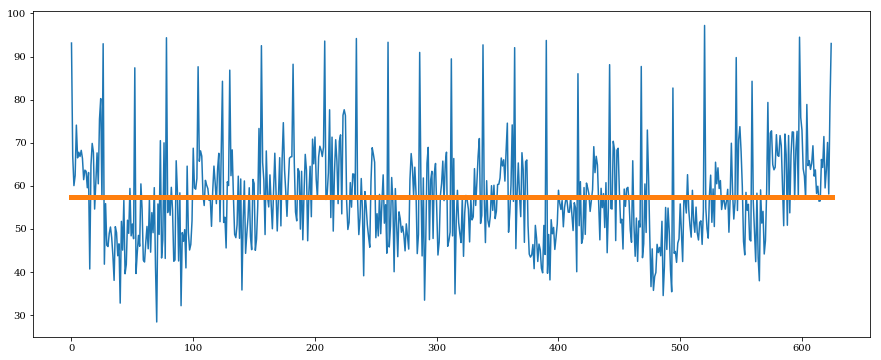

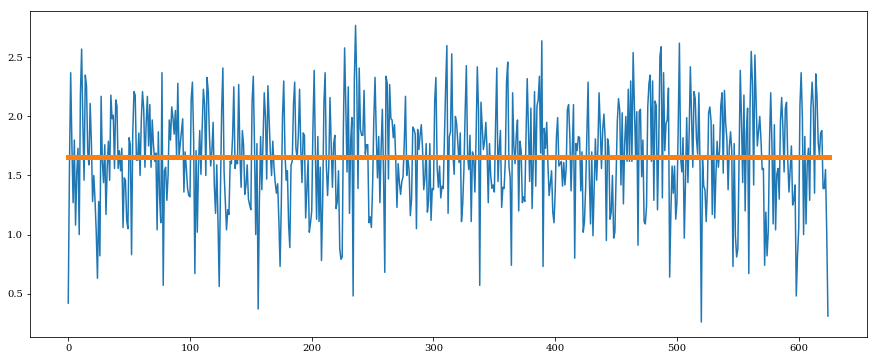

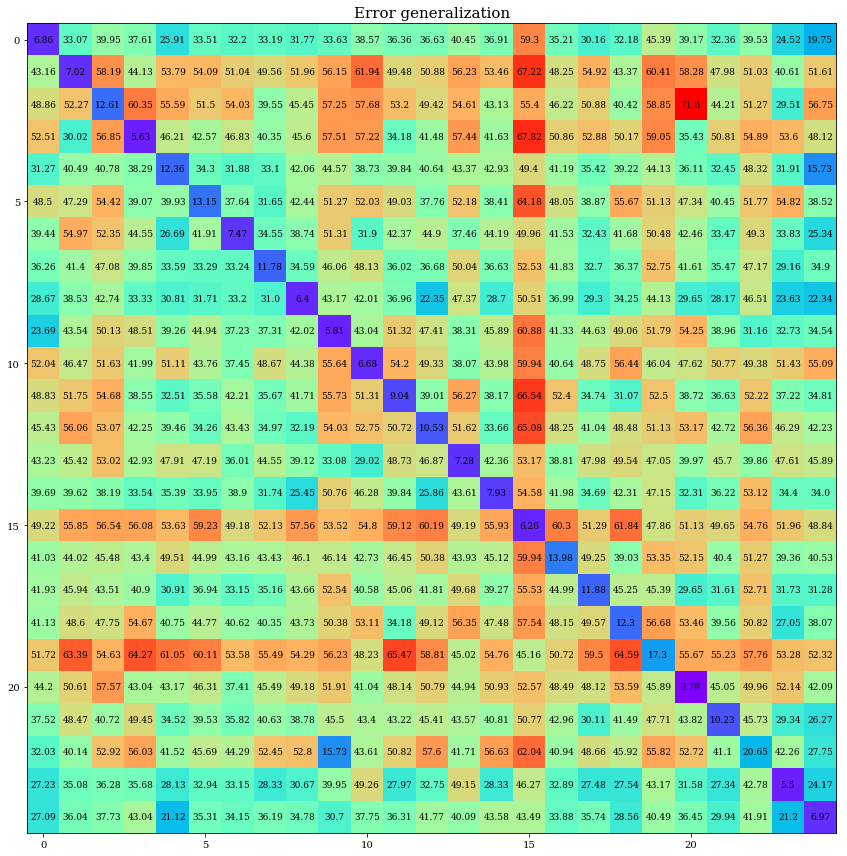

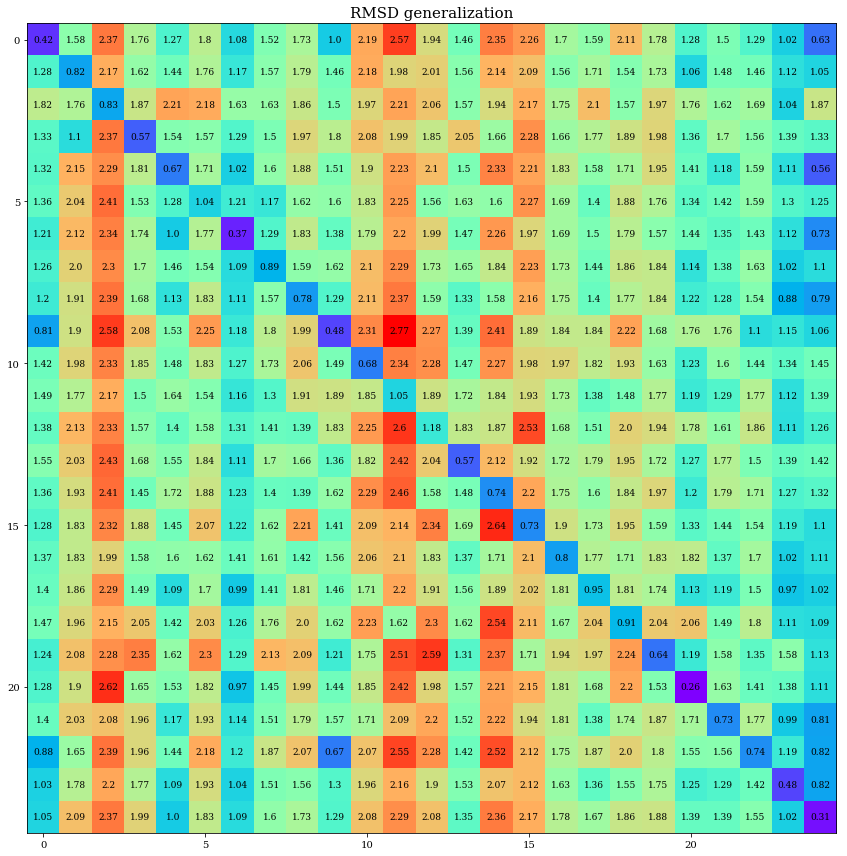

In [50]:
errors = []
RMSDs = []
for e,rms in results:
    errors.append(e)
    RMSDs.append(rms)

plt.figure(6, figsize=(15,6))
plt.plot(errors)
mean = np.mean(errors)
plt.plot([0, len(errors)], [mean, mean], linewidth=5)
plt.show()

plt.figure(7, figsize=(15,6))
plt.plot(RMSDs)
mean = np.mean(RMSDs)
plt.plot([0, len(RMSDs)], [mean, mean], linewidth=5)
plt.show()

error_matrix = np.empty([N,N], dtype=float)
rmsd_matrix = np.empty([N,N], dtype=float)
for i in range(0,N):
    for j in range(0,N):
        error_matrix[i][j] = 100-errors[N*i+j]
        rmsd_matrix[i][j] = RMSDs[N*i+j]
        
        
#Display error matrix  
fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
im = ax.imshow(error_matrix, cmap=colormap)
for i in range(0,N):
    for j in range(0,N):
        text = ax.text(j, i, error_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

ax.set_title("Error generalization", fontsize = 15)
fig.tight_layout()
plt.show()
plt.savefig('error_generalization.png', dpi=300)


#Display RMSD matrix
fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
im = ax.imshow(rmsd_matrix, cmap=colormap)
for i in range(0,N):
    for j in range(0,N):
        text = ax.text(j, i, rmsd_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

ax.set_title("RMSD generalization", fontsize = 15)
fig.tight_layout()
plt.show()
plt.savefig('rmsd_generalization.png', dpi=300)